# Basic Hands-On 1: Neural networks for regression - a simple energy reconstruction

Neural networks often solve two sets of problems: classification or regression. Typical regression tasks are energy, angular or Xmax reconstruction, in which a number is estimated rather than a class category. Instead of an energy bin, regression problems require a float number as estimated energy. Today we will cover a very basic regression problem and reconstruct the energy of artificially generated cosmic-ray data. 

In [36]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Set device (GPU if available, mps on Mac, else CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")


### 1. Generate artificial data

Instead of loading a benchmark data set, we will regenerate our own data set.
In our example, the energy is estimated from the number of muons and the arrival angle.

When generating random numbers, a random, manual seed is used to make the generated numbers reproducible. This is essential in data analysis because we do not want to get different results each time when we run our analysis. So, each time you run this function, the random number generator will provide exactly the same numbers. 


In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Generate synthetic cosmic ray shower data
def generate_cosmic_ray_data(n_samples=100):
    # Generate random parameters: number of muons, shower angles (in radians)
    num_muons = torch.randint(10, 100, (n_samples, 1)).float()  # Random number of muons
    arrival_angle = torch.rand(n_samples, 1) * 2 * 3.14159  # Random angle between 0 and 2π

    # Simulated energy reconstruction: E = a * num_muons^2 + b * angle + c - pure example, no relation to the real world
    a, b, c = 0.5, 1.0, 10.0
    energy = a * (num_muons ** 2) + b * arrival_angle + c

    return torch.cat((num_muons, arrival_angle), dim=1), energy # concatenate tensors

We want to divide our sample into training and test set. This is usually done randomly because otherwise our network might learn the positions of each data point in the data set. However, we can omit this step here because we just generated the data randomly.

Let's visualize the data first:


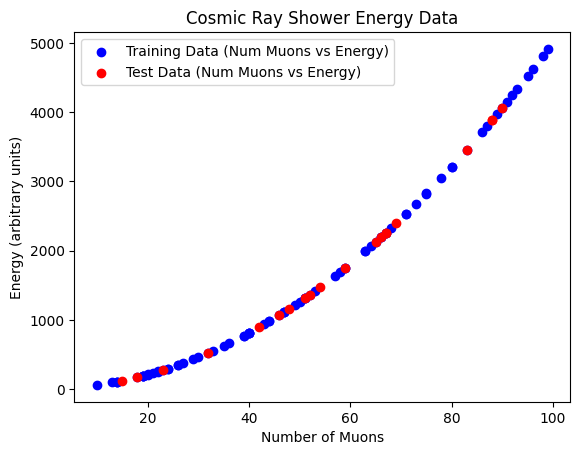

In [3]:
# Generate training and test data
n_train = 80
n_test = 20
X_train, y_train = generate_cosmic_ray_data(n_samples=n_train)
X_test, y_test = generate_cosmic_ray_data(n_samples=n_test)

# Visualize the generated data
plt.scatter(X_train[:, 0].numpy(), y_train.numpy(), label="Training Data (Num Muons vs Energy)", color='blue')
plt.scatter(X_test[:, 0].numpy(), y_test.numpy(), label="Test Data (Num Muons vs Energy)", color='red')
plt.title("Cosmic Ray Shower Energy Data")
plt.xlabel("Number of Muons")
plt.ylabel("Energy (arbitrary units)")
plt.legend()
plt.show()

Training and test data do follow the same function, as it should. We can proceed now to create a simple neural network, as we did in the classification task.


### 2. Create a simple neural network

We already know the structure of a simple neural network from the classification of hand-written digits and can create a similar structure. Neural networks are essentially the same for regression and classification. However, the main difference is the output layer. Regression predicts continuous values as a real-valued number. Classification predicts discrete categories in terms of a class label or a probability distribution. These differences require different output layers.  Classification networks do need an output dimension matching the number of categories to be predicted. In regression, the output shape has the dimension of one. Our network has a single neuron in the output layer with a linear activation function (e.g., no activation or identity function) to produce a continuous output instead of one category as in classification.

We create a class which has flexible arguments (the dimesions of the layers).

In [4]:
class CosmicRayNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(CosmicRayNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, 1)  # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation
        x = torch.relu(self.fc2(x))  # Apply ReLU activation
        x = self.fc3(x)  # Output layer (no activation)
        return x

In [5]:
# Initialize the model, loss function, and optimizer
input_size = 2  # Two input features: number of muons and arrival angle
hidden_size1 = 64
hidden_size2 = 32
model = CosmicRayNN(input_size, hidden_size1, hidden_size2)
print(model)

CosmicRayNN(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


### 3. Train and evaluate model

Another main difference between neural networks for regression and classification is the loss function. Classification uses loss functions suited for categorical outputs, such as Cross-Entropy Loss or Binary Cross-Entropy Loss for binary classification. Regression tasks require loss functions suitable for continuous outputs, such as Mean Squared Error (MSE) or Mean Absolute Error (MAE).

We create a training and evaluation function as we did in the previous exercise.

In [8]:
# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training function
def train_cosmic_ray_model(model, X_train, y_train, criterion, optimizer, epochs=100):
    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    model.train()
    losses = []
    for epoch in range(epochs):
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Record the loss
        losses.append(loss.item())
        
        # Print loss for every 10th epoch
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    
    return losses

# Evaluation function
def evaluate_cosmic_ray_model(model, X_test, y_test, criterion):
    model = model.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        loss = criterion(outputs, y_test)
    print(f'Test Loss: {loss.item():.4f}')
    return outputs


A loss curve is a visual representation of how a deep neural network’s loss function changes during training. It is commonly used to monitor and diagnose the learning process. Loss curves typically plot the loss value against the number of training epochs for both the training set and validation set.

Ther training loss curve represents how well the model fits the training data over time. A decreasing training loss indicates that the model is learning from the data.


The validation loss curve measures the model’s performance on unseen validation data. It helps detect overfitting and underfitting by comparing it to the training loss.

In [12]:
def loss_function_plot(epochs,losses):
    plt.plot(range(epochs), losses)
    plt.title("Loss Curve during Training")
    plt.xlabel("Epochs")
    #plt.yscale('log')
    plt.ylabel("Mean Squared Error Loss")
    plt.show()

Epoch [10/100], Loss: 1831706.3750
Epoch [20/100], Loss: 1604097.0000
Epoch [30/100], Loss: 1389012.8750
Epoch [40/100], Loss: 1190813.2500
Epoch [50/100], Loss: 1013167.3125
Epoch [60/100], Loss: 858743.4375
Epoch [70/100], Loss: 728957.4375
Epoch [80/100], Loss: 623835.9375
Epoch [90/100], Loss: 542039.8125
Epoch [100/100], Loss: 481068.5000


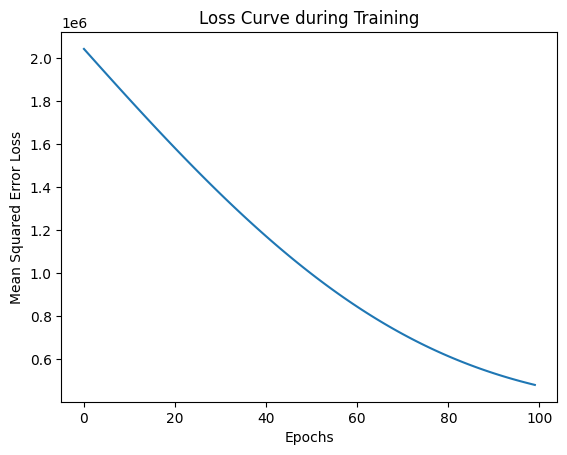

In [13]:
# Train the model and plot the loss curve
epochs = 100
losses = train_cosmic_ray_model(model, X_train, y_train, criterion, optimizer, epochs=epochs)

# Plot the loss curve
loss_function_plot(epochs,losses)

Let's evaluate the model on the test set.

In [9]:
# Evaluate the model on the test set
outputs = evaluate_cosmic_ray_model(model, X_test, y_test, criterion)

# Print a few predictions vs actual values
print("\nSample Predictions vs Actual Values:")
for i in range(10):
    print(f"Predicted: {outputs[i].item():.3f}, Actual: {y_test[i].item():.3f}")


Test Loss: 3879086.7500

Sample Predictions vs Actual Values:
Predicted: 256.208, Actual: 2191.871
Predicted: 348.416, Actual: 4064.764
Predicted: 92.754, Actual: 278.211
Predicted: 257.760, Actual: 2256.523
Predicted: 321.859, Actual: 3459.281
Predicted: 75.083, Actual: 176.793
Predicted: 268.139, Actual: 2394.816
Predicted: 186.310, Actual: 1164.590
Predicted: 201.157, Actual: 1364.310
Predicted: 62.096, Actual: 125.978


## Exercise: Parameter-tuning

Perform a hyperparameter search to improve the prediction. A hyperparameter search is a systematic search over all flexible variables in the model

Visualize the results.

In [14]:
def train_model(model, X_train, y_train, criterion, optimizer, epochs=100):
    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(X_train)  # Forward pass
        loss = criterion(outputs, y_train)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

def evaluate_model(model, X_test, y_test, criterion):
    model = model.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        loss = criterion(outputs, y_test)
    return loss.item()

In [41]:
def hyperparameter_tuning(X_train, y_train, X_test, y_test):
    learning_rate = 0.001  # Fixed learning rate
    hidden_units_list = [14, 32, 64, 128]
    epochs = 100

    # Initialize test loss storage
    test_losses = np.zeros((len(hidden_units_list), len(hidden_units_list)))

    # Hyperparameter tuning for a fixed learning rate
    for i, hidden_units1 in enumerate(hidden_units_list):
        for j, hidden_units2 in enumerate(hidden_units_list):
            model = CosmicRayNN(input_size=2, hidden_size1=hidden_units1, hidden_size2=hidden_units2)
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

            # Train the model
            train_model(model, X_train, y_train, criterion, optimizer, epochs)

            # Evaluate the model on the test set
            val_loss = evaluate_model(model, X_test, y_test, criterion)
            test_losses[i, j] = val_loss  # Store test loss

            print(f'Hidden Units 1: {hidden_units1}, Hidden Units 2: {hidden_units2}, Test Loss: {val_loss:.4f}')

    # Plot the results as a heatmap using Matplotlib
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.imshow(test_losses, cmap="Blues", origin="upper")

    # Add colorbar
    fig.colorbar(cax, label="Test Loss")

    # Set tick labels
    ax.set_xticks(np.arange(len(hidden_units_list)))
    ax.set_yticks(np.arange(len(hidden_units_list)))
    ax.set_xticklabels(hidden_units_list)
    ax.set_yticklabels(hidden_units_list)

    # Add labels and title
    ax.set_xlabel("Hidden Layer 2 Units")
    ax.set_ylabel("Hidden Layer 1 Units")
    ax.set_title(f"Test Loss for Different Hidden Layer Sizes (LR={learning_rate})")

    # Show text values inside cells
    for i in range(len(hidden_units_list)):
        for j in range(len(hidden_units_list)):
            ax.text(j, i, f"{test_losses[i, j]:.2f}", ha="center", va="center", color="black")

    plt.show()


Hidden Units 1: 14, Hidden Units 2: 14, Test Loss: 4745556.0000
Hidden Units 1: 14, Hidden Units 2: 32, Test Loss: 4611289.5000
Hidden Units 1: 14, Hidden Units 2: 64, Test Loss: 4447140.5000
Hidden Units 1: 14, Hidden Units 2: 128, Test Loss: 3586870.5000
Hidden Units 1: 32, Hidden Units 2: 14, Test Loss: 4436938.5000
Hidden Units 1: 32, Hidden Units 2: 32, Test Loss: 4257197.0000
Hidden Units 1: 32, Hidden Units 2: 64, Test Loss: 4288626.5000
Hidden Units 1: 32, Hidden Units 2: 128, Test Loss: 3821718.7500
Hidden Units 1: 64, Hidden Units 2: 14, Test Loss: 4046499.2500
Hidden Units 1: 64, Hidden Units 2: 32, Test Loss: 3828916.5000
Hidden Units 1: 64, Hidden Units 2: 64, Test Loss: 3443621.7500
Hidden Units 1: 64, Hidden Units 2: 128, Test Loss: 2165365.7500
Hidden Units 1: 128, Hidden Units 2: 14, Test Loss: 3336331.7500
Hidden Units 1: 128, Hidden Units 2: 32, Test Loss: 3472054.5000
Hidden Units 1: 128, Hidden Units 2: 64, Test Loss: 1899657.6250
Hidden Units 1: 128, Hidden Units 

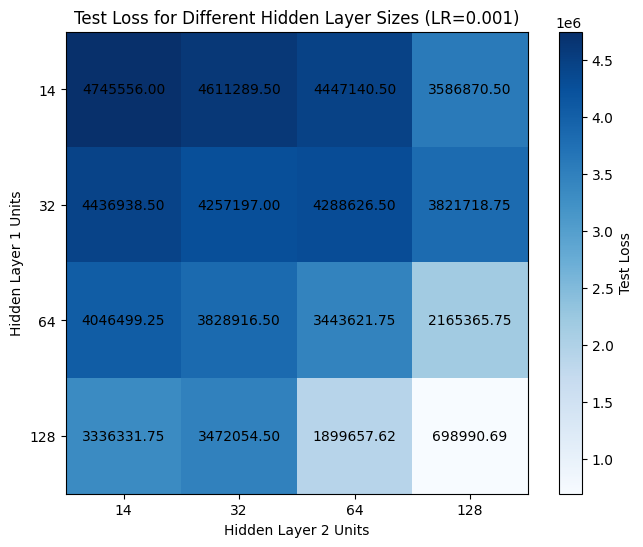

In [42]:
best_model = hyperparameter_tuning(X_train, y_train, X_test, y_test)

**Learning Rates**: We tested two learning rates, 0.01 and 0.001.
A lower learning rate often allows for more fine-tuned adjustments to the weights but may lead to longer training times, while a higher learning rate can accelerate convergence but might overshoot optimal solutions.

**Hidden Units**: We varied the number of hidden units in the first and second hidden layer. Increasing the number of hidden units allows the model to capture more complex patterns in the data, but it also increases the risk of overfitting, especially if the training data is limited.


**Performance Metrics**: After training, we evaluated the model on the test set using mean squared error (MSE) as the loss metric. The results indicated that certain combinations of learning rates and hidden units yielded lower test losses, indicating better generalization to unseen data. The best-performing model was determined by the configuration that minimized the validation loss.

In [32]:
# Evaluate the model on the test set
outputs = evaluate_cosmic_ray_model(best_model, X_test, y_test, criterion)

# Print a few predictions vs actual values
print("\nSample Predictions vs Actual Values:")
for i in range(10):
    print(f"Predicted: {outputs[i].item():.3f}, Actual: {y_test[i].item():.3f}")


Test Loss: 227717.1094

Sample Predictions vs Actual Values:
Predicted: 2355.486, Actual: 2191.871
Predicted: 3237.154, Actual: 4064.764
Predicted: 732.415, Actual: 278.211
Predicted: 2449.055, Actual: 2256.523
Predicted: 2971.641, Actual: 3459.281
Predicted: 518.196, Actual: 176.793
Predicted: 2455.645, Actual: 2394.816
Predicted: 1712.672, Actual: 1164.590
Predicted: 1872.539, Actual: 1364.310
Predicted: 440.341, Actual: 125.978


We can visulalize the prediction:

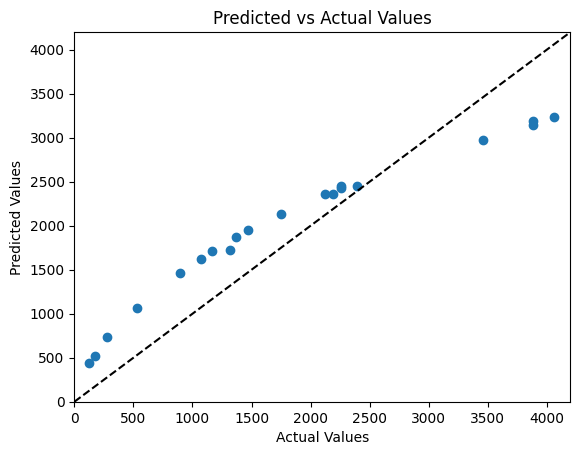

In [45]:
plt.scatter(y_test.cpu().numpy(), outputs.cpu().numpy())
plt.plot(np.linspace(0,4200),np.linspace(0,4200),ls='--',color='black')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.xlim(0.,4200)
plt.ylim(0.,4200)
plt.show()